<a href="https://colab.research.google.com/github/dk-wei/ml-algo-implementation/blob/main/Ensemble_Learning_NLP_XGBoost_w_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source blog: [Text Classification by XGBoost & Others: A Case Study Using BBC News Articles](https://pub.towardsai.net/text-classification-by-xgboost-others-a-case-study-using-bbc-news-articles-5d88e94a9f8)

In [ ]:
!pip install -U sentence-transformers

# Getting the data

In [4]:
import pandas as pd

bbc_text_df = pd.read_csv('https://raw.githubusercontent.com/amirziai/cse6242-project/master/resources/datasets/bbc-text.csv',  index_col=0).reset_index()
bbc_text_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Data Exploration & Visualisation

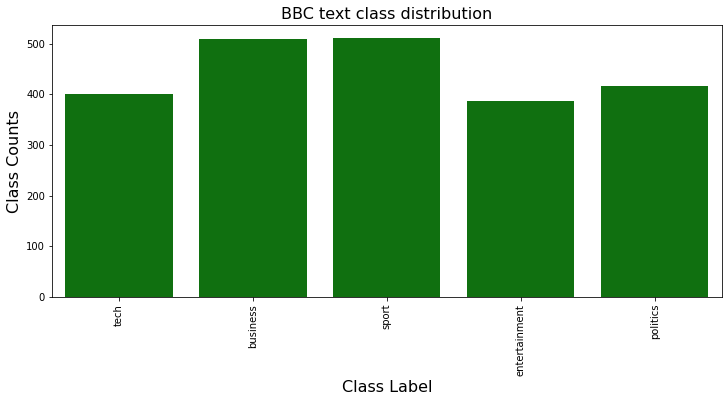

In [6]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=bbc_text_df.category, color='green')
plt.title('BBC text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

A typical text cleaning process involves the following steps
1. Conversion to lowercase
2. Removal of punctuations
3. Removal of integers, numbers
4. Removal of extra spaces
5. Removal of tags (like `<html>`, `<p>` etc)
6. Removal of stop words (like ‘and’, ‘to’, ‘the’ etc)
7. Stemming (Conversion of words to root form)

In [7]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:  
        s = f(s)
    return s

In [12]:
# before cleaning
bbc_text_df.iloc[2,1]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

In [11]:
# after cleaning
clean_text(bbc_text_df.iloc[2,1])

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

In [28]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

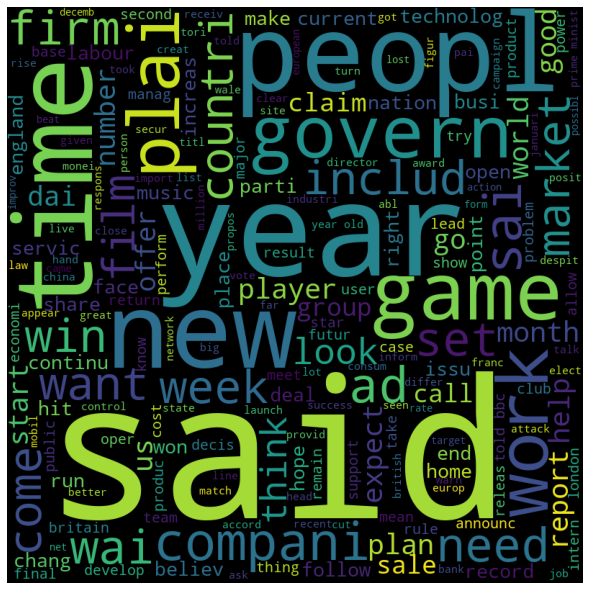

In [29]:
texts = ''
for index, item in bbc_text_df.iterrows():
    texts = texts + ' ' + clean_text(item['text'])
    
plot_word_cloud(texts)

In [30]:
def plot_word_cloud_for_category(bbc_text_df, category):
    text_df = bbc_text_df.loc[bbc_text_df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

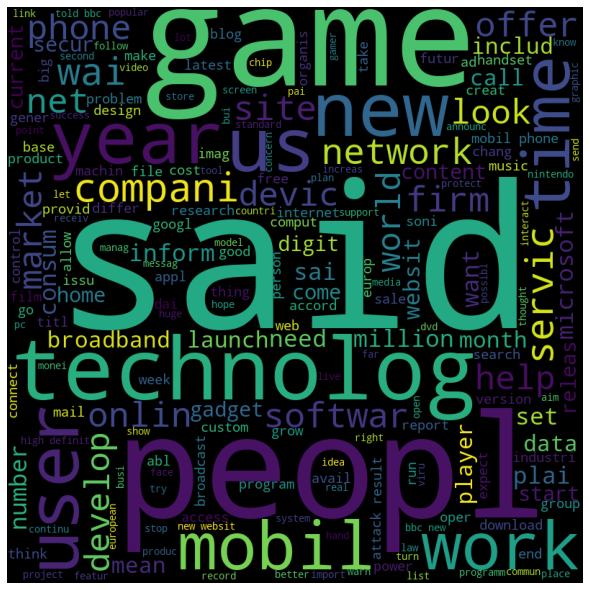

In [31]:
plot_word_cloud_for_category(bbc_text_df,'tech')

# Vector Space Modelling & Building the Pipeline

Vector space modeling is essential for any NLP problem. We will try with the two most popular vector space models: ‘Doc2Vec’ & ‘Tf-Idf’. First, we will split the data into features and categories.

In [17]:
df_x = bbc_text_df['text']
df_y = bbc_text_df['category']

# Doc2Vec

We will use Doc2Vec API of the ‘gensim’ library and write a generic ‘Doc2VecTransformer’

In [14]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [49]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1')


In [54]:
from tqdm.notebook import tqdm

In [64]:
df_x = bbc_text_df['text']
df_y = bbc_text_df['category']

In [ ]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)

In [46]:
doc2vec_features

matrix([[-1.27373949e-01, -3.14913131e-02, -1.19217575e-01, ...,
         -2.07499549e-01,  3.06506939e-02, -1.59082890e-01],
        [ 4.13593743e-03, -1.14612158e-04,  6.46600872e-03, ...,
          1.20106526e-02, -6.40092324e-03,  7.02656945e-03],
        [-1.06471904e-01,  6.77347463e-03, -1.10378176e-01, ...,
         -1.84806064e-01,  4.54070866e-02, -1.52055204e-01],
        ...,
        [-4.19183075e-03,  1.48354186e-04, -3.27624986e-03, ...,
          4.51481342e-03, -8.98366212e-04, -9.43947176e-04],
        [-2.05011994e-01,  1.97865702e-02, -1.98810294e-01, ...,
         -3.69861186e-01,  8.62678140e-02, -2.80078679e-01],
        [ 2.02563917e-03,  9.00327112e-04, -3.91055923e-03, ...,
          4.97392612e-03, -9.55186842e-04,  4.78391163e-03]],
       dtype=float32)

## Doc2Vec & LogisticRegression pipeline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

## Doc2Vec & RandomForest pipeline

In [ ]:
pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

## Doc2Vec & XGBoost pipeline

In [ ]:
pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

‘Doc2Vec’ is not doing good.
We will see ‘Tf-Idf’ vector space model

# TF-IDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [58]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [61]:
tfidf_vectors
#print(tfidf_vectors)

<2225x18755 sparse matrix of type '<class 'numpy.float64'>'
	with 180571 stored elements in Compressed Sparse Row format>

(2225, 18755) : 2225 docs and 18755 tokens

## Tf-Idf & LogisticRegression


In [29]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.8966292134831461


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Tf-Idf & RandomForest

In [34]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.9447191011235955


## Tf-Idf & XGBoost

In [35]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.9334831460674158


# Explanation of the results

Though the task is extremely simple in our case, but we can see seemingly advanced xx2vec context-based embedding is not **silver bulllet** to NLP techs.

Though ‘Doc2Vec’ is a more advanced model in NLP rather than ‘Tf-Idf’, but still in our case, it is not giving proper results. We have tried with a linear, bagging & boosting based classifier respectively.

This reason can be explained. In our dataset, each ‘text’ field contains several words/tokens which are determining its category and the frequency of those is quite high. **So making a context-sensitive model may over-complicate the situation or dilute this information**. As the frequency of some tokens is high in some text categories, it is contributing large enough values in determining ‘Tf-Idf’. Also, ‘texts’ are domain-specific.

For example it is highly probable that ‘blair’ word will be present in ‘politics’ category rather than ‘sport’. So existence of this is contributing to ‘Tf-Idf’.

Furthermore, ‘Doc2Vec’ model is more suitable for very well written grammatically correct texts. In our case, texts are quite rough in nature.
One example of grammatically correct text could be ‘Wikipedia’ texts.
It is also proven in various examples and Data Scientist’s experiments that though ‘Tf-Idf’ model is inferior as compared to ‘Doc2Vec’, but still it gives better result while classifying very domain specific texts.